# **Dependencies**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from tensorflow.keras.models import Sequential, Model, SimpleRNN
from tensorflow.keras.layers import LSTM, Dense,Dropout, Input, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.regularizers import l2
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs

## **Figure 26.**  
**Comparison of decision boundaries for three classifiers on a non-linear dataset**

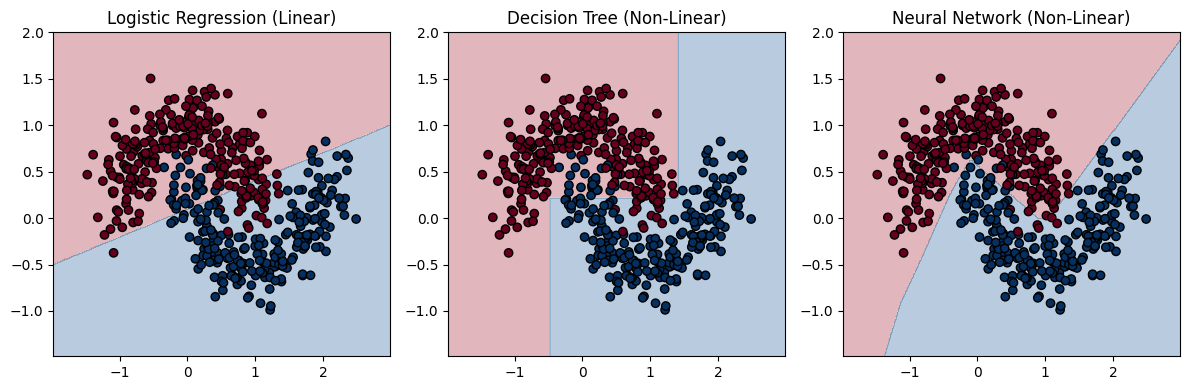

In [ ]:
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)

log_reg = LogisticRegression()
tree_clf = DecisionTreeClassifier(max_depth=4)
mlp_clf = MLPClassifier(hidden_layer_sizes=(10,), max_iter=5000, random_state=42)

log_reg.fit(X, y)
tree_clf.fit(X, y)
mlp_clf.fit(X, y)

def plot_decision_boundary(model, X, y, ax, title):
    h = 0.01
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.RdBu)
    ax.set_title(title)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_decision_boundary(log_reg, X, y, axes[0], "Logistic Regression (Linear)")
plot_decision_boundary(tree_clf, X, y, axes[1], "Decision Tree (Non-Linear)")
plot_decision_boundary(mlp_clf, X, y, axes[2], "Neural Network (Non-Linear)")

plt.tight_layout()
plt.show()

## **Code Block 5.1:**
**Data collection**

                     Last Price  Volume
Date                                   
2024-08-13 09:00:00   4130.1001   11611
2024-08-13 09:30:00   4120.3999    5735
2024-08-13 10:00:00   4125.0000    2156
2024-08-13 10:30:00   4125.0000    1847
2024-08-13 11:00:00   4127.5000    1466


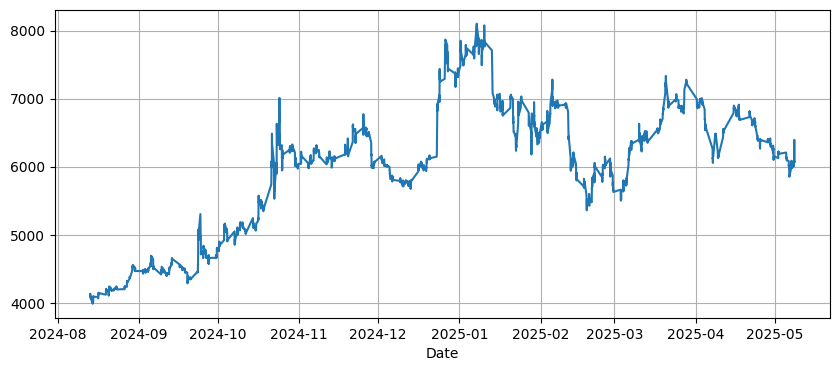

In [6]:
amber = pd.read_excel("/content/data_1.xlsx")
amber = amber.set_index("Date")
amber = amber.sort_index()
print(amber.head())

plt.figure(figsize= (10,4))
plt.plot(amber.index, amber['Last Price'])
plt.title('Price')
plt.xlabel('Date')
plt.grid()
plt.show()

In [7]:
start_date = amber.index.min()
end_date = amber.index.max()
print(f"Date Range: {start_date} to {end_date}")
print(amber.shape)

Date Range: 2024-08-13 09:00:00 to 2025-05-08 15:00:00
(2540, 2)


## **Code Block 5.2:**
**Histogram and box plots**


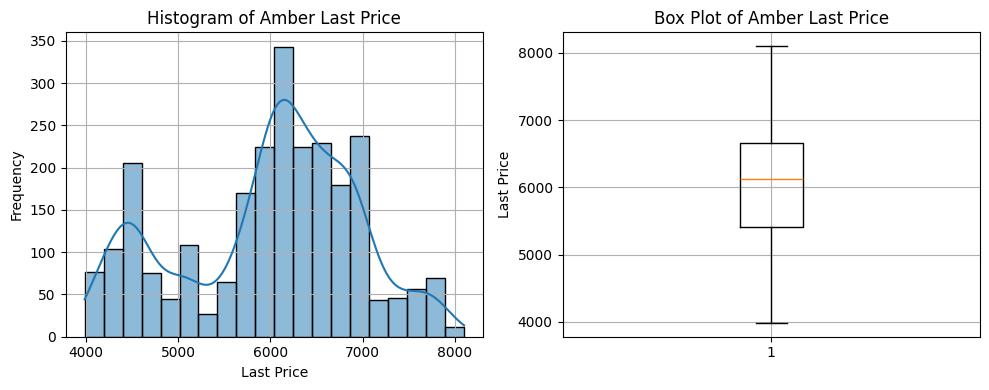

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(amber['Last Price'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Histogram of Amber Last Price')
axes[0].set_xlabel('Last Price')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

axes[1].boxplot(amber['Last Price'])
axes[1].set_title('Box Plot of Amber Last Price')
axes[1].set_ylabel('Last Price')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## **Code Block 5.3:**
**Log returns and volatility estimation**

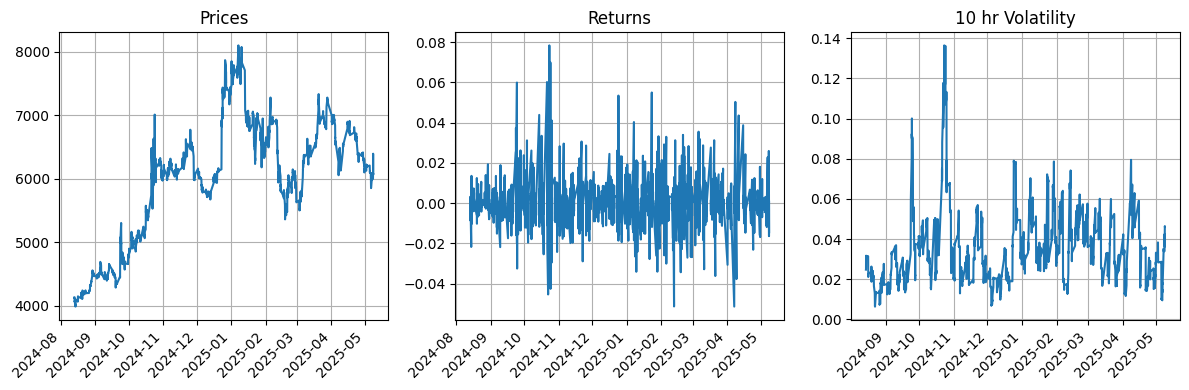

In [8]:
amber['Returns'] = np.log(amber['Last Price'] / amber['Last Price'].shift(1))
amber['Volatility'] = amber['Returns'].rolling(window=20).std() * np.sqrt(20)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(amber['Last Price'])
axes[0].set_title('Prices')
axes[0].grid()
plt.sca(axes[0])
plt.xticks(rotation=45, ha='right')

axes[1].plot(amber['Returns'])
axes[1].set_title('Returns')
axes[1].grid()
plt.sca(axes[1])
plt.sca(axes[1])
plt.xticks(rotation=45, ha='right')

axes[2].plot(amber['Volatility'])
axes[2].set_title('10 hr Volatility')
axes[2].grid()
plt.sca(axes[2])
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

## **Code Block 5.4:**
**Indicative anomaly using RSI technical indicator**


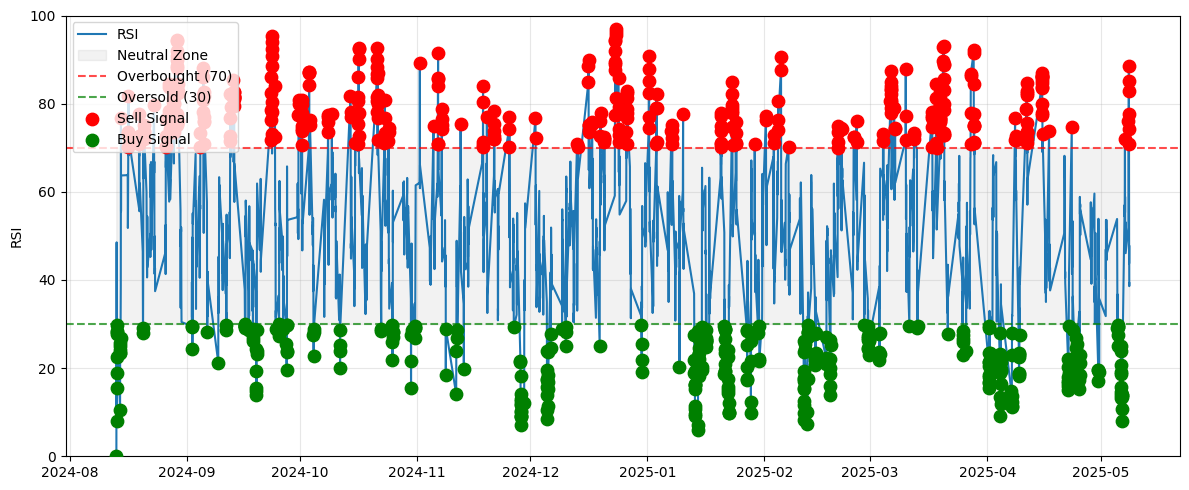

In [10]:
delta = amber['Last Price'].diff()
gain = delta.where(delta > 0, 0).ewm(span=14, adjust=False).mean()
loss = -delta.where(delta < 0, 0).ewm(span=14, adjust=False).mean()
rs = gain / loss
amber['RSI'] = 100 - (100 / (1 + rs))

amber['RSI_Signal'] = np.where(amber['RSI'] > 70, 1, np.where(amber['RSI'] < 30, -1, 0))

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(amber.index, amber['RSI'], label='RSI', linewidth=1.5)
ax.fill_between(amber.index, 30, 70, alpha=0.1, color='gray', label='Neutral Zone')

# Overbought/Oversold thresholds
ax.axhline(70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
ax.axhline(30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')

# Signal markers
ax.scatter(
    amber[amber['RSI_Signal'] == 1].index,
    amber[amber['RSI_Signal'] == 1]['RSI'],
    color='red', marker='o', s=80, label='Sell Signal', zorder=5)

ax.scatter(
    amber[amber['RSI_Signal'] == -1].index,
    amber[amber['RSI_Signal'] == -1]['RSI'],
    color='green', marker='o', s=80, label='Buy Signal', zorder=5)

ax.set_ylabel('RSI')
ax.set_title('Relative Strength Index (RSI) with Trading Signals')
ax.legend(loc='upper left')
ax.grid(alpha=0.3)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

## **Code Block 5.5:**
**Anomalies based on Z-score**




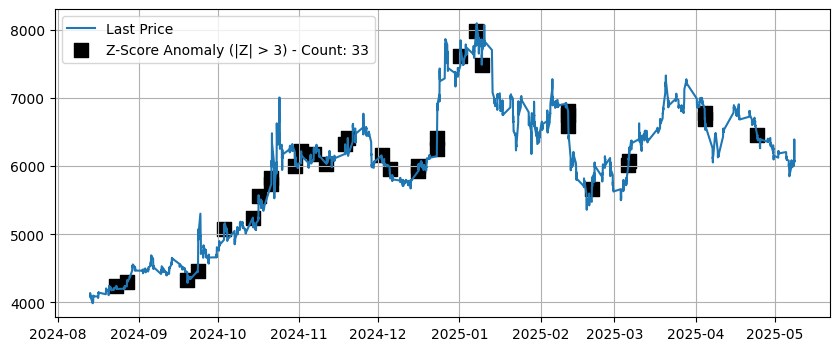

In [11]:
amber['Z_Score']=stats.zscore(amber['Last Price'])

window = 20
amber['Rolling_Mean'] = amber['Last Price'].rolling(window=window).mean()
amber['Rolling_Std'] = amber['Last Price'].rolling(window=window).std()
amber['Z_Score'] = (amber['Last Price'] - amber['Rolling_Mean']) / amber['Rolling_Std']

# Flag anomalies (|Z| > 3)
amber['Z_Anomaly'] = np.where(np.abs(amber['Z_Score']) > 3, 1, 0)

anomaly_count = amber['Z_Anomaly'].sum()

plt.figure(figsize=(10, 4))
plt.plot(amber.index, amber['Last Price'], label='Last Price')
plt.scatter(
    amber[amber['Z_Anomaly'] == 1].index,
    amber[amber['Z_Anomaly'] == 1]['Last Price'],
    color='black', marker='s', s=100,
    label=f'Z-Score Anomaly (|Z| > 3) - Count: {anomaly_count}')
plt.title('Price with Z-Score Anomalies')
plt.legend(loc='upper left')
plt.grid()

## **Code Block 5.6:**
**Combined Z-Score and RSI for anomalous points detection**


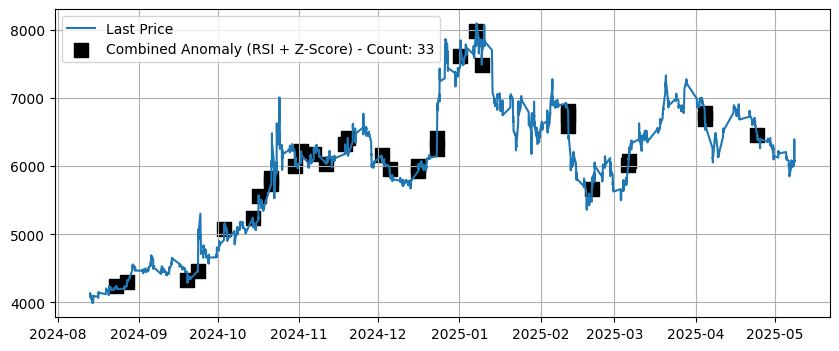

In [12]:
amber['Combined_Anomaly'] = np.where(
    ((amber['RSI'] > 70) | (amber['RSI'] < 30)) & (amber['Z_Anomaly'] == 1),
    1, 0)

anomaly_count = amber['Combined_Anomaly'].sum()

plt.figure(figsize=(10, 4))
plt.plot(amber.index, amber['Last Price'], label='Last Price')
plt.scatter(
    amber[amber['Combined_Anomaly'] == 1].index,
    amber[amber['Combined_Anomaly'] == 1]['Last Price'],
    color='black', marker='s', s=100,
    label=f'Combined Anomaly (RSI + Z-Score) - Count: {anomaly_count}')
plt.title('Price with Combined RSI + Z-Score Anomalies')
plt.legend()
plt.grid()
plt.show()

In [ ]:
amber.columns

Index(['Last Price', 'Volume', 'Returns', 'Volatility', 'RSI', 'RSI_Signal',
       'Z_Score', 'Rolling_Mean', 'Rolling_Std', 'Z_Anomaly',
       'Combined_Anomaly'],
      dtype='object')

## **Code Block 5.7:**
**Heatmap on anomalies based on Z-score**


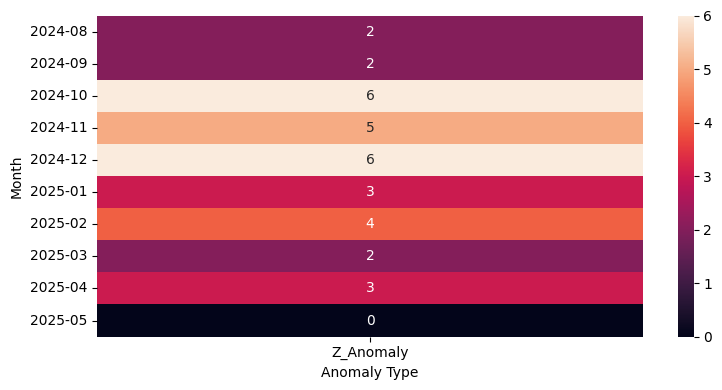

In [13]:
heatmap_data = amber[['Z_Anomaly']].copy()
heatmap_data['Month'] = amber.index.to_period('M').astype(str)
monthly_counts = heatmap_data.groupby('Month').sum()

plt.figure(figsize=(8, 4))
sns.heatmap(monthly_counts, annot=True, fmt="d", cbar=True)
plt.title("Monthly Anomaly Count Heatmap (Z-Score)")
plt.ylabel("Month")
plt.xlabel("Anomaly Type")
plt.tight_layout()
plt.show()

## **Code Block 5.8:**
**Synthetic dataset with outliers**


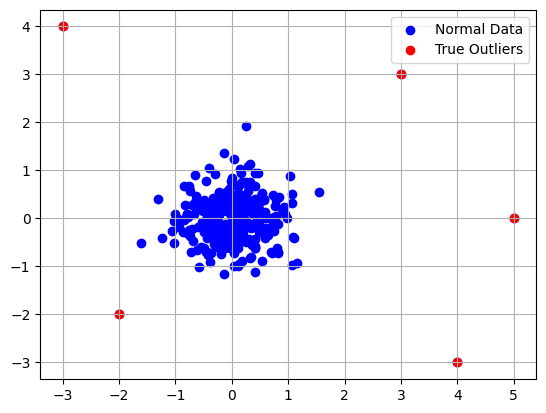

In [14]:
np.random.seed(42)
normal_data = 0.5 * np.random.randn(300, 2)

# Add outliers
outliers = np.array([
    [3, 3],
    [-2, -2],
    [4, -3],
    [-3, 4],
    [5, 0]])

# Combine into a single dataset
X = np.vstack([normal_data, outliers])

plt.scatter(X[:, 0], X[:, 1], c='blue', label='Normal Data')
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', label='True Outliers')
plt.title("Original Data (Normal vs. Outliers)")
plt.legend()
plt.grid()
plt.show()

## **Code Block 5.9:**
**Isolation Forest model training and outlier visualization**


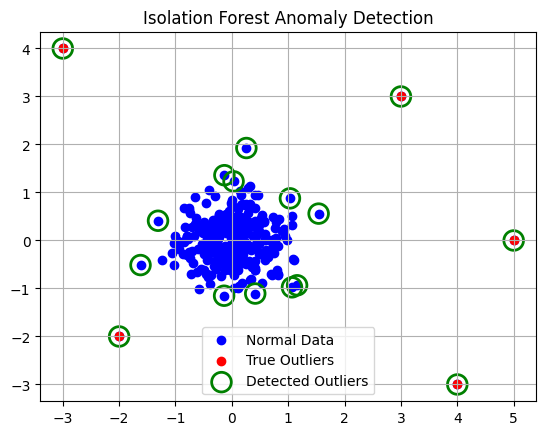

In [16]:
model = IsolationForest(contamination=0.05, random_state=42)
model.fit(X)
preds = model.predict(X)

# Extract outliers from predictions
outlier_mask = (preds == -1)
detected_outliers = X[outlier_mask]

plt.scatter(X[:, 0], X[:, 1], c='blue', label='Normal Data')
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', label='True Outliers')
plt.scatter(
    detected_outliers[:, 0],
    detected_outliers[:, 1],
    edgecolors='green',
    facecolors='none',
    s=200,
    linewidth=2,
    label='Detected Outliers')
plt.title("Isolation Forest Anomaly Detection")
plt.legend()
plt.grid()
plt.show()

## **Code Block 5.10:**
**Visualization of contamination effects**


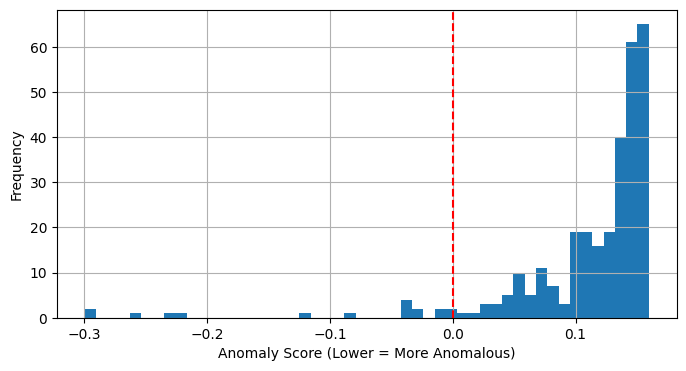

In [18]:
contamination=0.05
scores = model.decision_function(X)

plt.figure(figsize= (8,4))
plt.hist(scores, bins=50)
plt.axvline(x=np.percentile(scores, 100 * contamination), color='r', linestyle='--')
plt.xlabel("Anomaly Score (Lower = More Anomalous)")
plt.ylabel("Frequency")
plt.title("Threshold Set by Contamination Parameter")
plt.grid()
plt.show()

## **Code Block 5.11:**
**Isolation Forest implementation and anomaly visualization**




In [20]:
amber = amber.dropna(subset=['Last Price', 'Volume', 'Returns', 'Volatility'])

scaler = StandardScaler()
X = scaler.fit_transform(amber)

iso_forest = IsolationForest(contamination=0.01, random_state=42)
amber.loc[:,'Anomaly_IsoForest'] = iso_forest.fit_predict(X)

In [21]:
anomalies_iso = amber[amber['Anomaly_IsoForest'] == -1]

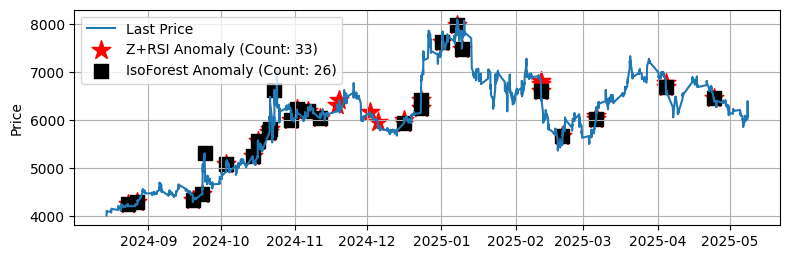

In [25]:
comb_anomaly_count = (amber['Combined_Anomaly'].sum())
iso_anomaly_count = len(anomalies_iso)

plt.figure(figsize=(8, 5))

ax1 = plt.subplot(2, 1, 1)
ax1.plot(amber.index, amber['Last Price'], label='Last Price')

ax1.scatter(
    amber[amber['Combined_Anomaly'] == 1].index,
    amber[amber['Combined_Anomaly'] == 1]['Last Price'],
    color='red', marker='*', s=200,
    label=f'Z+RSI Anomaly (Count: {comb_anomaly_count})')

ax1.scatter(
    anomalies_iso.index,
    anomalies_iso['Last Price'],
    color='black', marker='s', s=100,
    label=f'IsoForest Anomaly (Count: {iso_anomaly_count})')

ax1.set_ylabel('Price')
ax1.legend(loc='upper left')
ax1.set_title('Price with Combined and IsoForest Anomalies')
ax1.grid()

plt.tight_layout()
plt.show()

### **Figure 38.**
**ROC-AUC plot generated on synthetic data**

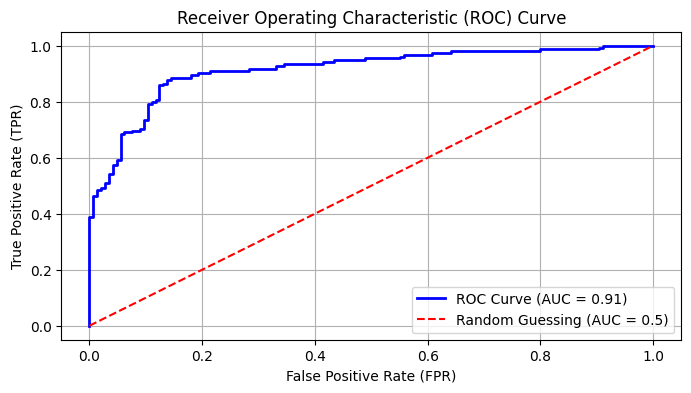

In [ ]:
X, y = make_classification(n_samples=1000, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

### **Figure 39.**
**Precision-recall Area Under the Curve (Imbalanced classes)**

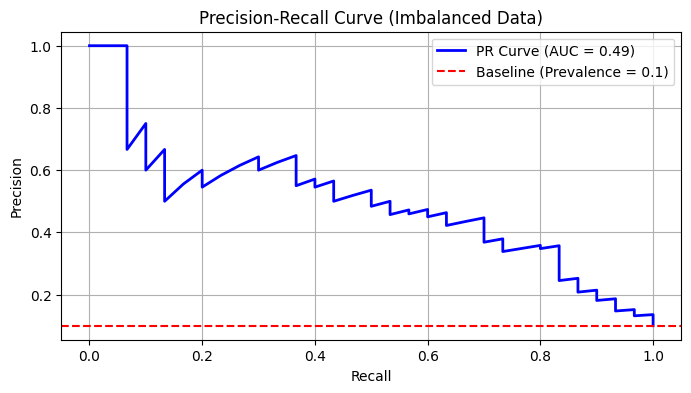

In [ ]:
X, y = make_classification(n_samples=1000, n_classes=2, weights=[0.9, 0.1], random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
y_probs = model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 4))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Imbalanced Data)')
plt.axhline(y=0.1, color='red', linestyle='--', label='Baseline (Prevalence = 0.1)')
plt.legend()
plt.grid(True)
plt.show()

## **Code Block 5.12:**
**ROC-AUC and PR-AUC curves**


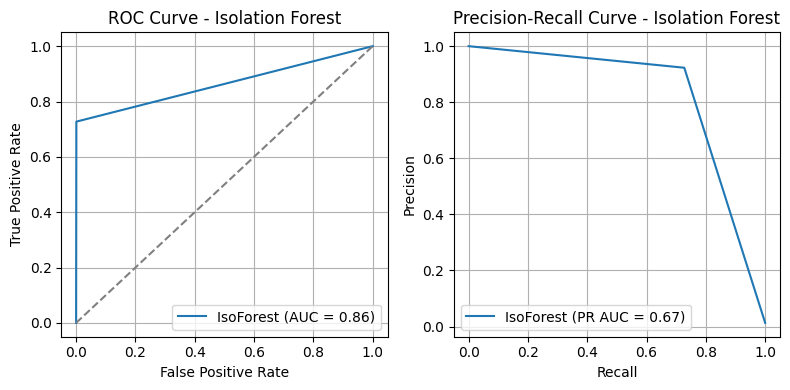

Precision: 0.9231
Recall: 0.7273
F1-Score: 0.8136


In [27]:
amber['True_Labels'] = amber['Combined_Anomaly']
amber['IsoForest_Anomaly_Label'] = np.where(amber['Anomaly_IsoForest'] == -1, 1, 0)

fpr_iso, tpr_iso, _ = roc_curve(amber['True_Labels'], amber['IsoForest_Anomaly_Label'])
roc_auc_iso = auc(fpr_iso, tpr_iso)

precision_iso, recall_iso, _ = precision_recall_curve(amber['True_Labels'], amber['IsoForest_Anomaly_Label'])
pr_auc_iso = average_precision_score(amber['True_Labels'], amber['IsoForest_Anomaly_Label'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# ROC Curve
ax1.plot(fpr_iso, tpr_iso, label=f'IsoForest (AUC = {roc_auc_iso:.2f})')
ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve - Isolation Forest')
ax1.legend(loc='lower right')
ax1.grid(True)

# Precision-Recall
ax2.plot(recall_iso, precision_iso, label=f'IsoForest (PR AUC = {pr_auc_iso:.2f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve - Isolation Forest')
ax2.legend(loc='lower left')
ax2.grid(True)

plt.tight_layout()
plt.show()

y_true = amber['Combined_Anomaly']
y_pred_iso = amber['Anomaly_IsoForest'].replace({-1: 1, 1: 0})

precision_iso = precision_score(y_true, y_pred_iso)
recall_iso = recall_score(y_true, y_pred_iso)
f1_iso = f1_score(y_true, y_pred_iso)

print(f"Precision: {precision_iso:.4f}")
print(f"Recall: {recall_iso:.4f}")
print(f"F1-Score: {f1_iso:.4f}")

## **Code Block 5.13:**
**Comparing RNN vs. LSTM Training Dynamics**

Generating synthetic fraud detection data...
Data shape: (1000, 20, 5)
  - Samples: 1000
  - Timesteps (sequence length): 20
  - Features per timestep: 5
  - Fraud cases: 96 (9.6%)

Data splits:
  Train: 640 samples
  Validation: 160 samples
  Test: 200 samples

Building Standard RNN model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Standard_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 20, 50)         │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,901 (30.86 KB)

 Trainable params: 7,901 (30.86 KB)

 Non-trainable params: 0 (0.00 B)

None

Building LSTM model...


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 20, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

None

TRAINING STANDARD RNN
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5992 - loss: 0.6848 - val_accuracy: 1.0000 - val_loss: 0.0917
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0573 - val_accuracy: 1.0000 - val_loss: 0.0109
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9977 - loss: 0.0179 - val_accuracy: 0.9937 - val_loss: 0.0277
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9989 - loss: 0.0090 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.002

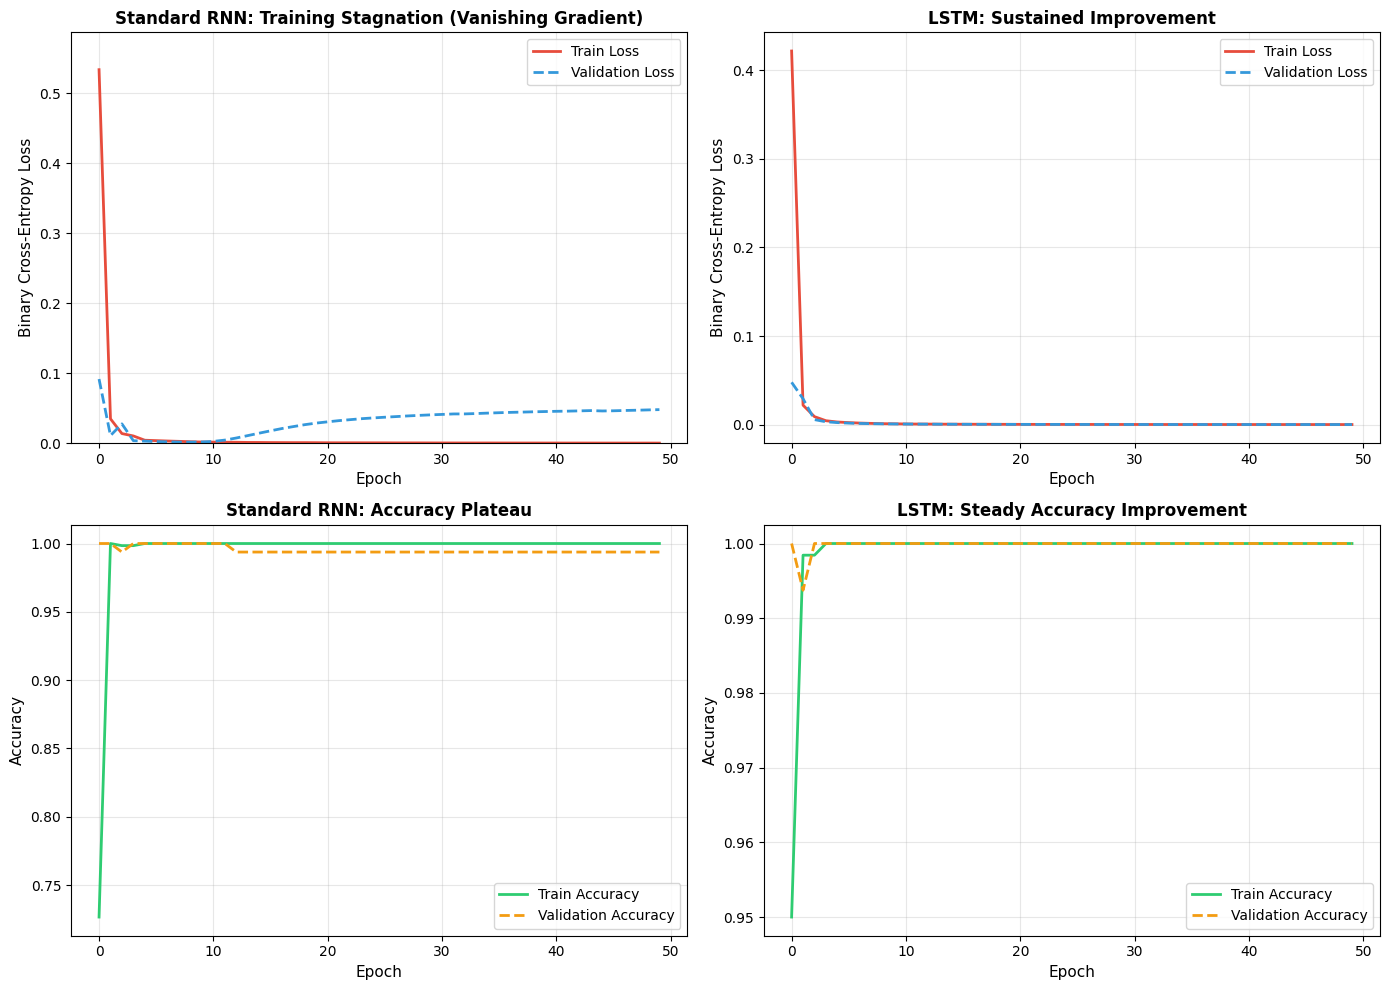


FINAL COMPARISON SUMMARY
       Model  Final Train Loss  Final Val Loss  Final Train Acc  Final Val Acc  Test Loss  Test Accuracy
Standard RNN          0.000202        0.048027              1.0        0.99375   0.000843            1.0
        LSTM          0.000067        0.000067              1.0        1.00000   0.000046            1.0

KEY OBSERVATIONS
1. RNN plateaus after ~1 epochs
2. LSTM continues improving through epoch 50
3. LSTM achieves 0.0% higher test accuracy
4. LSTM final loss is 94.6% lower than RNN


In [35]:
np.random.seed(42)
def generate_fraud_sequences(n_users=1000, seq_length=20, fraud_rate=0.1):
    n_features = 5
    X = np.zeros((n_users, seq_length, n_features))
    y = np.zeros(n_users)

    for i in range(n_users):
        is_fraud = np.random.random() < fraud_rate
        y[i] = int(is_fraud)

        if is_fraud:
            normal_length = int(0.7 * seq_length)
            # Normal transactions
            X[i, :normal_length, 0] = np.random.normal(100, 30, normal_length)  # amount
            X[i, :normal_length, 1] = np.random.uniform(0, 24, normal_length)   # time of day
            X[i, :normal_length, 2] = np.random.randint(0, 5, normal_length)    # location
            X[i, :normal_length, 3] = np.random.randint(0, 10, normal_length)   # category
            X[i, :normal_length, 4] = np.random.exponential(2, normal_length)   # velocity

            # Fraudulent burst in last 30%
            fraud_length = seq_length - normal_length
            X[i, normal_length:, 0] = np.random.normal(500, 200, fraud_length)  # high amounts
            X[i, normal_length:, 1] = np.random.uniform(0, 6, fraud_length)     # unusual times
            X[i, normal_length:, 2] = np.random.randint(5, 10, fraud_length)    # new locations
            X[i, normal_length:, 3] = np.random.randint(10, 15, fraud_length)   # unusual categories
            X[i, normal_length:, 4] = np.random.exponential(10, fraud_length)   # high velocity

        else:
            X[i, :, 0] = np.random.normal(100, 30, seq_length)
            X[i, :, 1] = np.random.uniform(6, 22, seq_length)  # normal hours
            X[i, :, 2] = np.random.choice([0, 1, 2], seq_length)  # familiar locations
            X[i, :, 3] = np.random.choice([0, 1, 2, 3, 4], seq_length)  # common categories
            X[i, :, 4] = np.random.exponential(2, seq_length)

    return X, y

print("Generating synthetic fraud detection data...")
X, y = generate_fraud_sequences(n_users=1000, seq_length=20, fraud_rate=0.1)

n_samples, timesteps, n_features = X.shape
print(f"Data shape: {X.shape}")
print(f"  - Samples: {n_samples}")
print(f"  - Timesteps (sequence length): {timesteps}")
print(f"  - Features per timestep: {n_features}")
print(f"  - Fraud cases: {y.sum():.0f} ({y.mean()*100:.1f}%)")

X_reshaped = X.reshape(-1, n_features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(n_samples, timesteps, n_features)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(f"\nData splits:")
print(f"  Train: {len(X_train)} samples")
print(f"  Validation: {len(X_val)} samples")
print(f"  Test: {len(X_test)} samples")

print("\nBuilding Standard RNN model...")
rnn_model = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=(timesteps, n_features)),
    Dropout(0.2),
    SimpleRNN(50),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
], name='Standard_RNN')

rnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

print(rnn_model.summary())

print("\nBuilding LSTM model...")
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(timesteps, n_features)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
], name='LSTM')

lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

print(lstm_model.summary())

epochs = 50
batch_size = 32

print("\n" + "="*80)
print("TRAINING STANDARD RNN")
print("="*80)
rnn_history = rnn_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    verbose=1)

print("\n" + "="*80)
print("TRAINING LSTM")
print("="*80)
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    verbose=1)

print("\n" + "="*80)
print("TEST SET EVALUATION")
print("="*80)

rnn_test_loss, rnn_test_acc = rnn_model.evaluate(X_test, y_test, verbose=0)
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test, y_test, verbose=0)

print(f"Standard RNN - Test Loss: {rnn_test_loss:.4f}, Test Accuracy: {rnn_test_acc:.4f}")
print(f"LSTM        - Test Loss: {lstm_test_loss:.4f}, Test Accuracy: {lstm_test_acc:.4f}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# RNN Training Loss
axes[0, 0].plot(rnn_history.history['loss'], label='Train Loss',
                linewidth=2, color='#e74c3c')
axes[0, 0].plot(rnn_history.history['val_loss'], label='Validation Loss',
                linewidth=2, color='#3498db', linestyle='--')
axes[0, 0].set_title('Standard RNN: Training Stagnation (Vanishing Gradient)',
                     fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Binary Cross-Entropy Loss', fontsize=11)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_ylim([0, max(rnn_history.history['loss'][:10]) * 1.1])

# LSTM Training Loss
axes[0, 1].plot(lstm_history.history['loss'], label='Train Loss',
                linewidth=2, color='#e74c3c')
axes[0, 1].plot(lstm_history.history['val_loss'], label='Validation Loss',
                linewidth=2, color='#3498db', linestyle='--')
axes[0, 1].set_title('LSTM: Sustained Improvement',
                     fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Binary Cross-Entropy Loss', fontsize=11)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3)

# RNN Training Accuracy
axes[1, 0].plot(rnn_history.history['accuracy'], label='Train Accuracy',
                linewidth=2, color='#2ecc71')
axes[1, 0].plot(rnn_history.history['val_accuracy'], label='Validation Accuracy',
                linewidth=2, color='#f39c12', linestyle='--')
axes[1, 0].set_title('Standard RNN: Accuracy Plateau',
                     fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('Accuracy', fontsize=11)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(alpha=0.3)

# LSTM Training Accuracy
axes[1, 1].plot(lstm_history.history['accuracy'], label='Train Accuracy',
                linewidth=2, color='#2ecc71')
axes[1, 1].plot(lstm_history.history['val_accuracy'], label='Validation Accuracy',
                linewidth=2, color='#f39c12', linestyle='--')
axes[1, 1].set_title('LSTM: Steady Accuracy Improvement',
                     fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch', fontsize=11)
axes[1, 1].set_ylabel('Accuracy', fontsize=11)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('rnn_vs_lstm_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("FINAL COMPARISON SUMMARY")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': ['Standard RNN', 'LSTM'],
    'Final Train Loss': [rnn_history.history['loss'][-1],
                         lstm_history.history['loss'][-1]],
    'Final Val Loss': [rnn_history.history['val_loss'][-1],
                       lstm_history.history['val_loss'][-1]],
    'Final Train Acc': [rnn_history.history['accuracy'][-1],
                        lstm_history.history['accuracy'][-1]],
    'Final Val Acc': [rnn_history.history['val_accuracy'][-1],
                      lstm_history.history['val_accuracy'][-1]],
    'Test Loss': [rnn_test_loss, lstm_test_loss],
    'Test Accuracy': [rnn_test_acc, lstm_test_acc]})

print(comparison_df.to_string(index=False))

print("\n" + "="*80)
print("KEY OBSERVATIONS")
print("="*80)
print(f"1. RNN plateaus after ~{np.argmin(np.diff(rnn_history.history['val_loss'][:15]) > -0.001) + 1} epochs")
print(f"2. LSTM continues improving through epoch {epochs}")
print(f"3. LSTM achieves {(lstm_test_acc - rnn_test_acc)*100:.1f}% higher test accuracy")
print(f"4. LSTM final loss is {(rnn_test_loss - lstm_test_loss)/rnn_test_loss*100:.1f}% lower than RNN")

## **Code Block 5.14:**
**LSTM network architecture and model implementation**


In [39]:
sequence_length = 20
features = ['Last Price', 'Volume', 'Returns', 'Volatility']

train, test = train_test_split(amber[features], test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train)
X_test_scaled = scaler.transform(test)

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(X_train_scaled, sequence_length)
X_test, y_test = create_sequences(X_test_scaled, sequence_length)

train_size = len(train) - sequence_length

model = Sequential([
    Input(shape=(sequence_length, len(features))),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.1),
    LSTM(32, activation='tanh'),
    Dense(len(features))])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(
    X_train, y_train,
    epochs = 50,
    batch_size = 32,
    validation_data = (X_test, y_test),
    callbacks = [early_stop],
    shuffle = False)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.7896 - val_loss: 0.2680
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.4832 - val_loss: 0.2646
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.4340 - val_loss: 0.2583
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.3904 - val_loss: 0.2469
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.3726 - val_loss: 0.2461
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.3545 - val_loss: 0.2435
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.3451 - val_loss: 0.2408
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.3360 - val_loss: 0.2383
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.3298 - val_loss: 0.2331
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.3260 - val_loss: 0.2301
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.3208 - val_loss: 0.2281
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.3

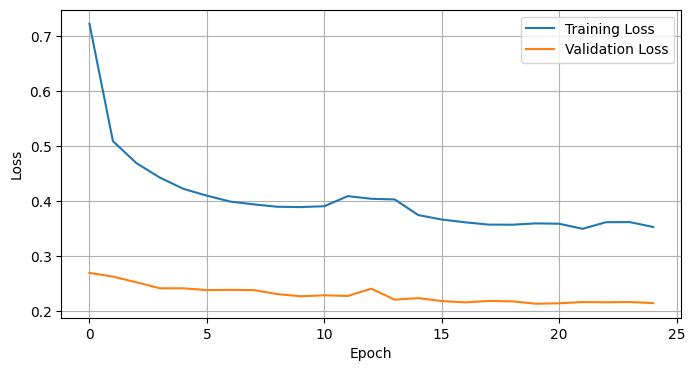

In [29]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

## **Code Block 5.15:**
**Loss Vs Epoch plots: Overfitting and Undefitting examples**

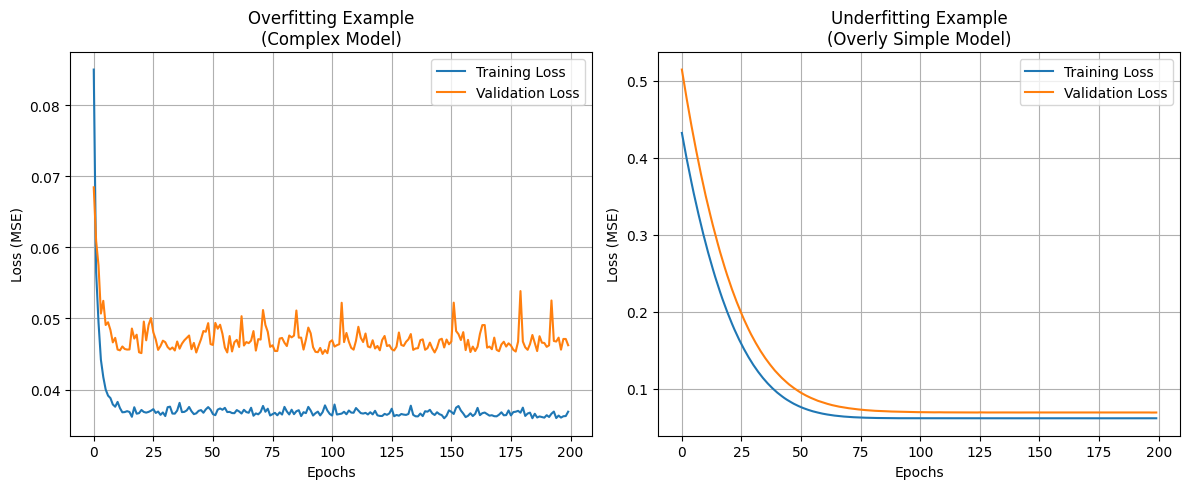

In [37]:
np.random.seed(42)
X = np.linspace(-1, 1, 1000)
y = X**3 + 0.2*np.random.randn(1000)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

plt.figure(figsize=(12, 5))

# Overfitting
plt.subplot(1, 2, 1)
overfit_model = Sequential([
    Input(shape=(1,)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)])
overfit_model.compile(optimizer='adam', loss='mse')
history = overfit_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                          epochs=200, verbose=0)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Overfitting Example\n(Complex Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Underfitting
plt.subplot(1, 2, 2)
underfit_model = Sequential([
    Input(shape=(1,)),
    Dense(1)])
underfit_model.compile(optimizer='adam', loss='mse')
history = underfit_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                           epochs=200, verbose=0)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Underfitting Example\n(Overly Simple Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## **Code Block 5.16:**
**LSTM anomaly detection on test data using trained model from Code block 5.15**

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


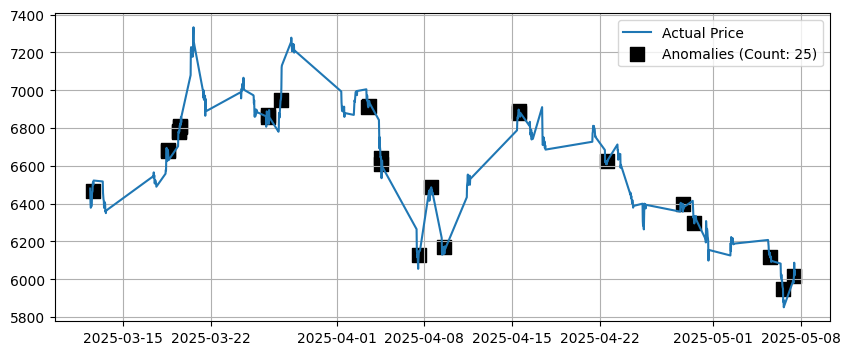

In [40]:
test_predictions = model.predict(X_test)
mse = np.mean(np.power(y_test - test_predictions, 2), axis=1)
threshold = np.percentile(mse, 95)
anomalies = mse > threshold

test_dates = amber.index[-len(y_test)-sequence_length:-sequence_length]
plt.figure(figsize=(10, 4))

actual_prices = amber['Last Price'].iloc[-len(y_test)-sequence_length:-sequence_length]
plt.plot(test_dates, actual_prices, label='Actual Price')

anomaly_indices = np.where(anomalies)[0]
anomaly_dates = test_dates[anomaly_indices]
anomaly_prices = actual_prices.iloc[anomaly_indices]

plt.scatter(anomaly_dates, anomaly_prices,
            color='black', marker='s', s=100, label=f'Anomalies (Count: {sum(anomalies)})')

plt.grid()
plt.legend()
plt.show()

## **Code Block 5.17:**
**Anomalies on entire dataset**

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


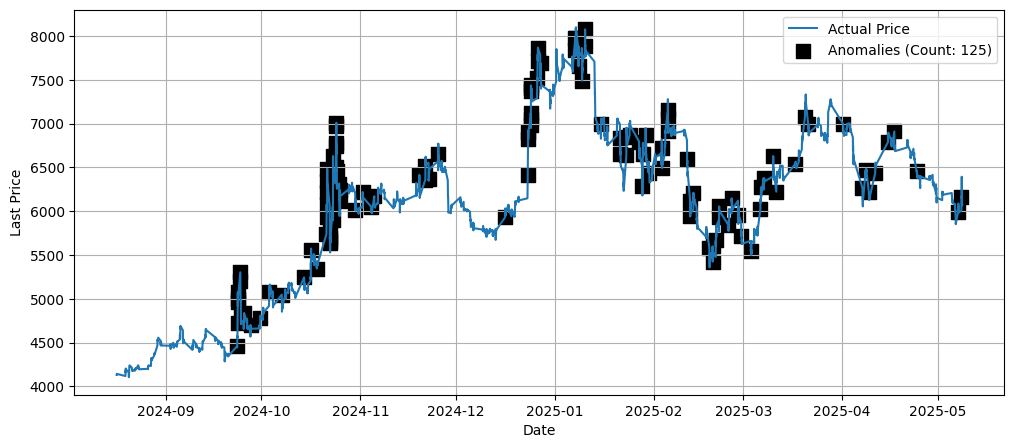

In [44]:
scaled_data = scaler.transform(amber[features])
X_all, y_all = create_sequences(scaled_data, sequence_length)
all_predictions = model.predict(X_all)

mse_all = np.mean(np.power(y_all - all_predictions, 2), axis=1)
threshold_all = np.percentile(mse_all, 95)
anomalies_all = mse_all > threshold_all

plt.figure(figsize=(12,5))

dates = amber.index[sequence_length:]
prices = amber['Last Price'].iloc[sequence_length:].values

plt.plot(dates, prices, label='Actual Price')

anomaly_indices_all = np.where(anomalies_all)[0]
plt.scatter(dates[anomaly_indices_all],
            prices[anomaly_indices_all],
            color='black', marker='s', s=100,
            label=f'Anomalies (Count: {sum(anomalies_all)})')

plt.title('LSTM Anomaly Detection on Entire Dataset')
plt.xlabel('Date')
plt.ylabel('Last Price')
plt.grid()
plt.legend()
plt.show()

## **Code Block 5.18:**
**LSTM model output: ROC-AUC and PR-AUC**


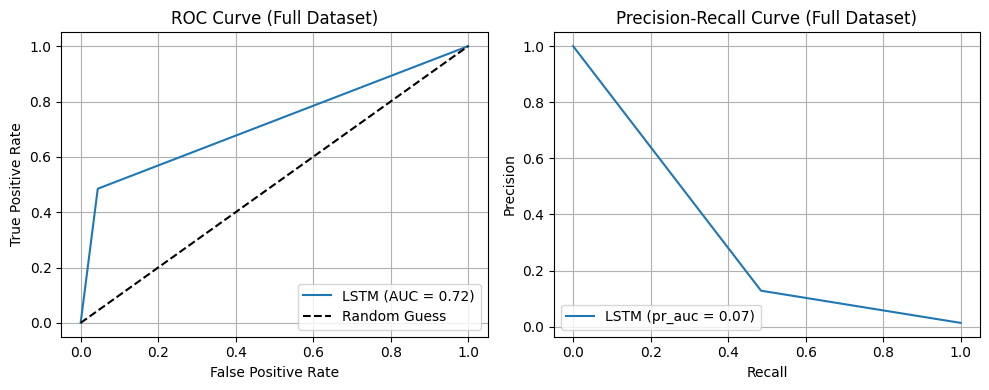

Anomaly Detection Metrics (95th percentile threshold):
- Precision: 0.1280
- Recall: 0.4848
- F1-Score: 0.2025
- Total Anomalies Detected: 125


In [46]:
amber['True_Labels'] = amber['Combined_Anomaly'].astype(int)
amber['LSTM_Anomaly'] = 0
amber.loc[amber.index[sequence_length:][anomalies_all], 'LSTM_Anomaly'] = 1
amber['LSTM_Anomaly'] = amber['LSTM_Anomaly'].astype(int)

filtered_amber = amber.dropna(subset=['True_Labels', 'LSTM_Anomaly'])

y_true = filtered_amber['True_Labels'][sequence_length:]
y_pred = filtered_amber['LSTM_Anomaly'][sequence_length:]


f1_lstm = f1_score(y_true, y_pred)
precision_lstm = precision_score(y_true, y_pred)
recall_lstm = recall_score(y_true, y_pred)

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred)
pr_auc = average_precision_score(y_true, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(fpr, tpr, label=f'LSTM (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], 'k--', label='Random Guess')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve (Full Dataset)')
ax1.legend(loc='lower right')
ax1.grid()

ax2.plot(recall_curve, precision_curve, label=f'LSTM (pr_auc = {pr_auc:.2f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve (Full Dataset)')
ax2.legend(loc='lower left')
ax2.grid()

plt.tight_layout()
plt.show()

print("Anomaly Detection Metrics (95th percentile threshold):")
print(f"- Precision: {precision_lstm:.4f}")
print(f"- Recall: {recall_lstm:.4f}")
print(f"- F1-Score: {f1_lstm:.4f}")
print(f"- Total Anomalies Detected: {sum(anomalies_all)}")


## **Code Block 5.19:**
**Autoencoder implementation and error plot visualization**


In [48]:
features = ['Last Price', 'Volume', 'Returns', 'Volatility']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(amber[features])

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.1564 - val_loss: 0.6118
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0237 - val_loss: 0.5896
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9924 - val_loss: 0.5742
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8889 - val_loss: 0.5544
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9021 - val_loss: 0.5308
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9444 - val_loss: 0.4522
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6445 - val_loss: 0.3773
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6167 - val_loss: 0.3182
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4247 - val_loss: 0.3252
Epoch 10/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3710 - val_loss: 0.3289
Epoch 11/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3641 - val_loss: 0.3191
Epoch 12/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

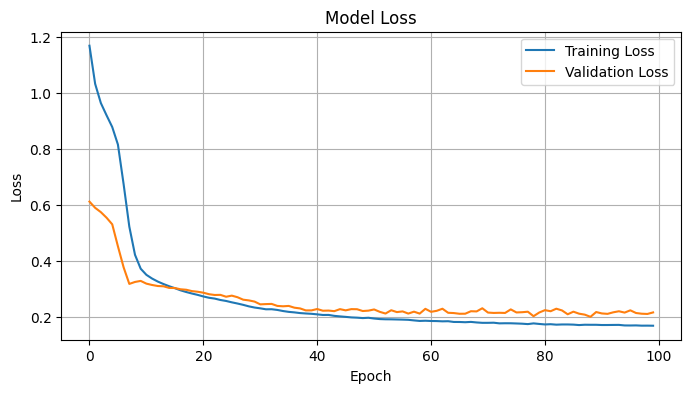

In [49]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

input_dim = scaled_data.shape[1]
encoding_dim = 2

input_layer = Input(shape=(input_dim,))
encoder = Dense(16, activation="relu")(input_layer)
encoder = Dense(8, activation="relu")(encoder)
encoder = Dense(encoding_dim, activation="relu")(encoder)
decoder = Dense(16, activation="relu")(encoder)
decoder = Dense(8, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = autoencoder.fit(
    train_data, train_data,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    verbose=1)

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

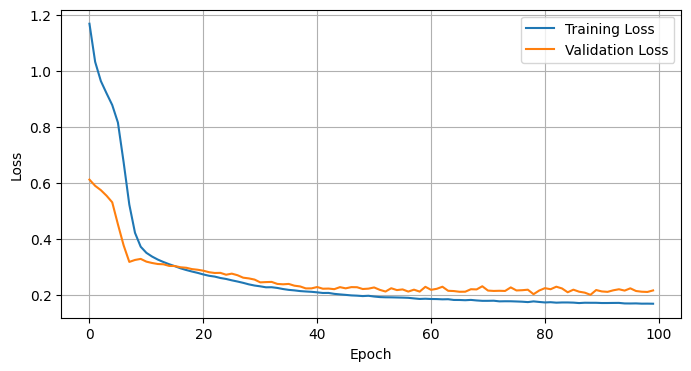

In [52]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

In [50]:
predictions = autoencoder.predict(scaled_data)
mse = np.mean(np.power(scaled_data - predictions, 2), axis=1)

threshold = np.percentile(mse, 95)

anomalies = mse > threshold

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


## **Code Block 5.20:**
**Anomaly detection using Autoencoder**

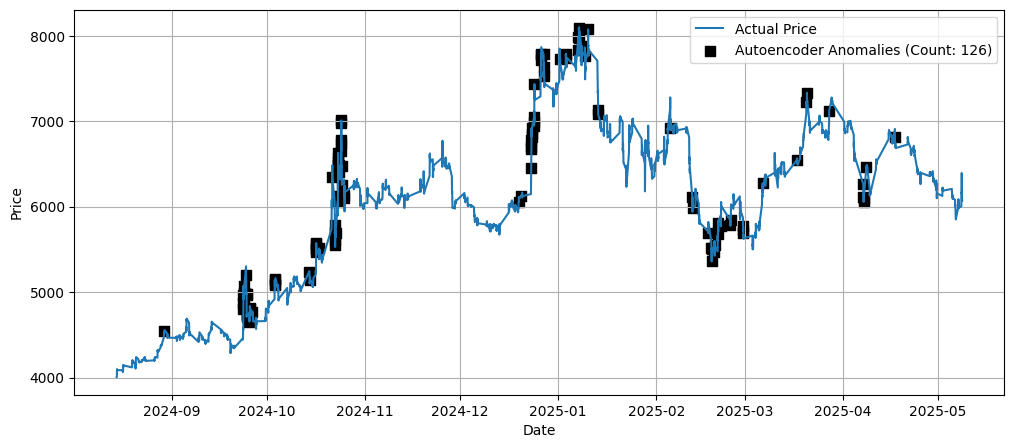

In [51]:
plt.figure(figsize=(12, 5))
plt.plot(amber['Last Price'], label='Actual Price')
plt.scatter(amber.index[anomalies],
            amber.loc[anomalies, 'Last Price'],
            color='black', marker='s', s=50,
            label=f'Autoencoder Anomalies (Count: {sum(anomalies)})')
# plt.title('Price with Autoencoder Detected Anomalies')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

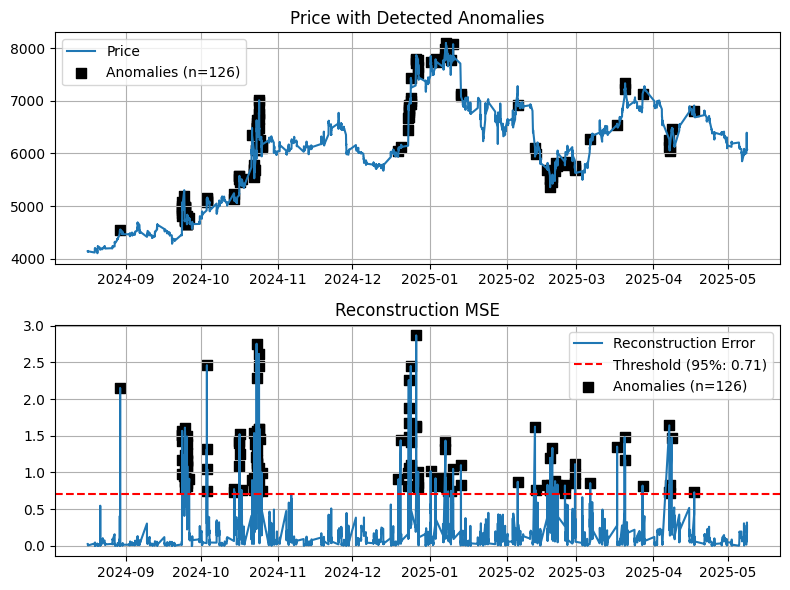

In [55]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

anomaly_count = sum(anomalies)
ax1.plot(amber.index[sequence_length-1:], amber['Last Price'][sequence_length-1:],
        label='Price')
anomalies_adjusted = anomalies[sequence_length - 1:]

ax1.scatter(amber.index[sequence_length-1:][anomalies_adjusted],
           amber['Last Price'][sequence_length-1:][anomalies_adjusted],
           color='black', marker='s', s=50, label=f'Anomalies (n={anomaly_count})')
ax1.set_title('Price with Detected Anomalies')
ax1.legend()
ax1.grid()

ax2.plot(amber.index[sequence_length-1:], mse[sequence_length - 1:], label='Reconstruction Error')
ax2.axhline(threshold, color='r', linestyle='--', label=f'Threshold (95%: {threshold:.2f})')

ax2.scatter(amber.index[sequence_length-1:][anomalies_adjusted], mse[sequence_length - 1:][anomalies_adjusted],
           color='black', marker='s', s=50, label=f'Anomalies (n={anomaly_count})')
ax2.set_title('Reconstruction MSE')
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

## **Code Block 5.21:**
**Autoencoder performance: ROCAUC and PRAUC**

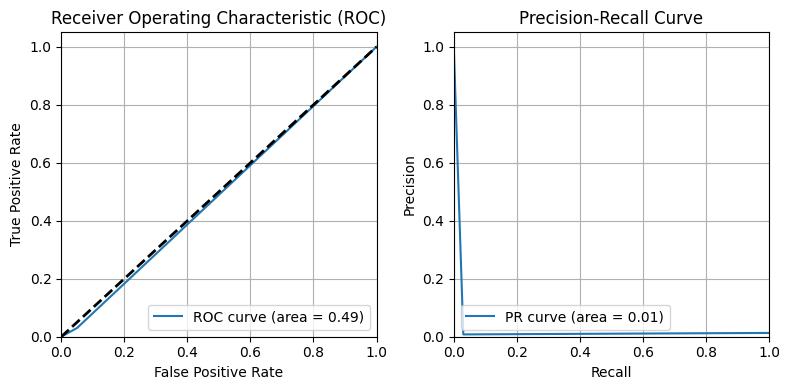

Precision: 0.0079
Recall: 0.0303
F1-Score: 0.0126


In [56]:
amber['True_Labels'] = amber['Combined_Anomaly'].astype(int)

amber['Autoencoder_Anomaly_Label'] = 0
amber.loc[anomalies, 'Autoencoder_Anomaly_Label'] = 1

fpr, tpr, _ = roc_curve(amber['True_Labels'], amber['Autoencoder_Anomaly_Label'])
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(amber['True_Labels'], amber['Autoencoder_Anomaly_Label'])
pr_auc = average_precision_score(amber['True_Labels'], amber['Autoencoder_Anomaly_Label'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# ROC Curve
ax1.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC)')
ax1.legend(loc="lower right")
ax1.grid()

# PR Curve
ax2.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="lower left")
ax2.grid()

plt.tight_layout()
plt.show()

precision = precision_score(amber['True_Labels'], anomalies)
recall = recall_score(amber['True_Labels'], anomalies)
f1 = f1_score(amber['True_Labels'], anomalies)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

## **Code Block 5.22:**
**One Class SVM performance on synthetic dataset**

              precision    recall  f1-score   support

    Gaussian       0.94      0.85      0.89        20
     Uniform       0.86      0.95      0.90        20

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40



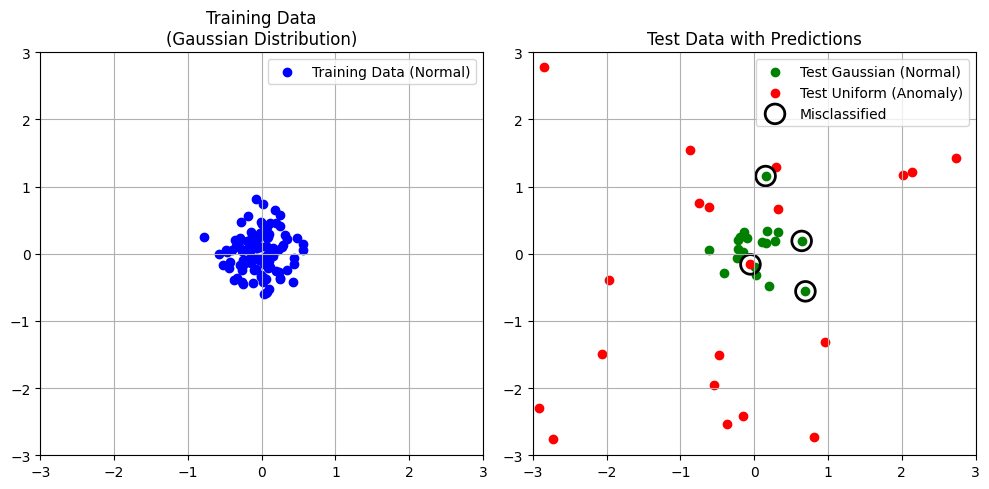

In [57]:
np.random.seed(42)

train_data = np.random.normal(loc=0, scale=0.3, size=(100, 2))

# test data (20 Gaussian + 20 Uniform points)
test_gaussian = np.random.normal(loc=0, scale=0.3, size=(20, 2))
test_uniform = np.random.uniform(low=-3, high=3, size=(20, 2))
test_data = np.vstack([test_gaussian, test_uniform])

# True labels (0=Gaussian/normal, 1=Uniform/anomaly)
y_true = np.array([0]*20 + [1]*20)

# Train One-Class SVM
ocsvm = OneClassSVM(nu=0.05, kernel="rbf", gamma="auto")  # nu controls sensitivity
ocsvm.fit(train_data)

y_pred = ocsvm.predict(test_data)
y_pred = np.where(y_pred == 1, 0, 1)

print(classification_report(y_true, y_pred, target_names=["Gaussian", "Uniform"]))

plt.figure(figsize=(10, 5))

# training data
plt.subplot(1, 2, 1)
plt.scatter(train_data[:, 0], train_data[:, 1], c='blue', label='Training Data (Normal)')
plt.title("Training Data\n(Gaussian Distribution)")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.legend()
plt.grid()

# test data with predictions
plt.subplot(1, 2, 2)
plt.scatter(test_gaussian[:, 0], test_gaussian[:, 1],
            c='green', label='Test Gaussian (Normal)')
plt.scatter(test_uniform[:, 0], test_uniform[:, 1],
            c='red', label='Test Uniform (Anomaly)')

errors = (y_pred != y_true)
plt.scatter(test_data[errors, 0], test_data[errors, 1],
            s=200, facecolors='none', edgecolors='black', linewidths=2,
            label='Misclassified')
plt.title("Test Data with Predictions")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## **Code Block 5.23:**
**LOF performance on synthetic dataset**

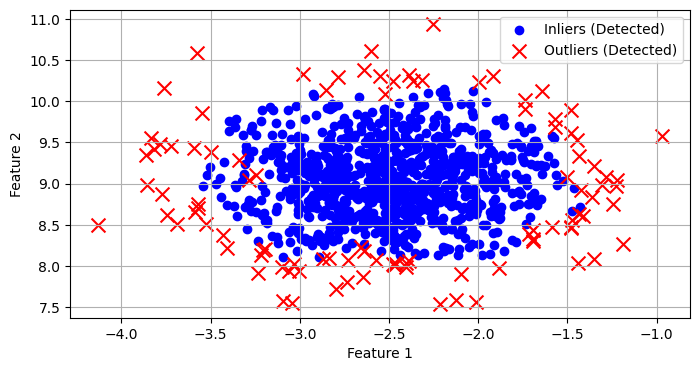

In [67]:
X, _ = make_blobs(n_samples=1000, centers=1, cluster_std=0.5, random_state=42)

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
outliers = lof.fit_predict(X)

inliers = X[outliers == 1]
detected_outliers = X[outliers == -1]

plt.figure(figsize=(8, 4))
plt.scatter(inliers[:, 0], inliers[:, 1], c='blue', label='Inliers (Detected)')
plt.scatter(detected_outliers[:, 0], detected_outliers[:, 1], c='red', label='Outliers (Detected)', marker='x', s=100)

plt.title("Local Outlier Factor Anomaly Detection")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

## **Code Block 5.24:**
**Implementation of One-Class SVM and LOF**


In [68]:
features = ['Last Price', 'Volume', 'Returns', 'Volatility']

X = amber[features].values

# One-Class SVM
svm_model = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
svm_preds = svm_model.fit_predict(X)
amber['Anomaly_SVM'] = (svm_preds == -1).astype(int)

# LOF
lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_preds = lof_model.fit_predict(X)
amber['Anomaly_LOF'] = (lof_preds == -1).astype(int)

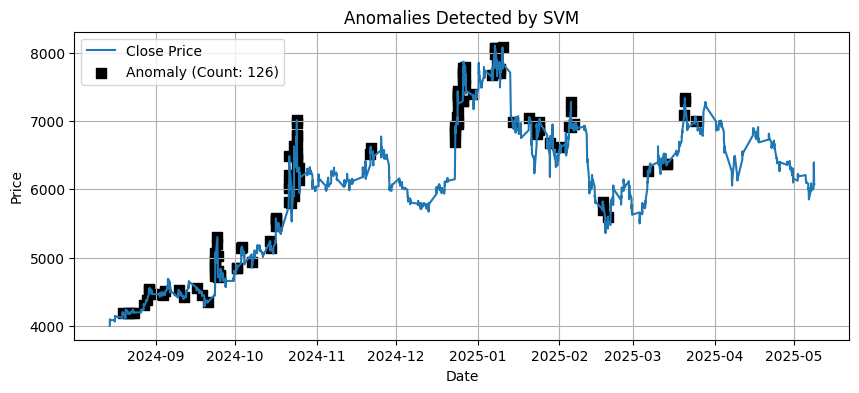

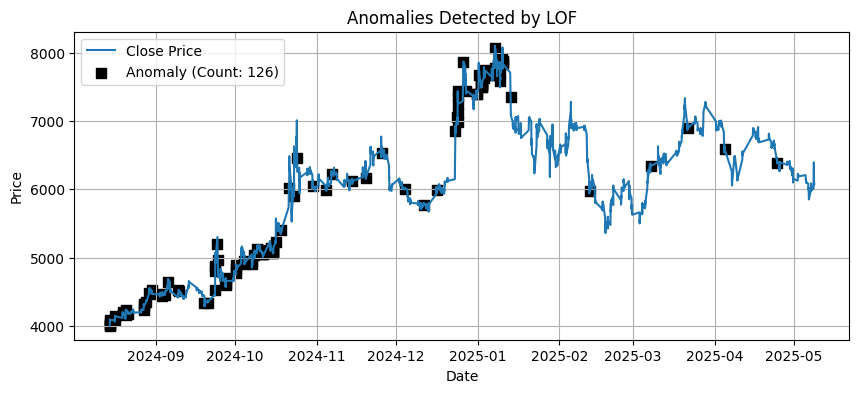

In [69]:
method_columns = {
    'SVM': amber['Anomaly_SVM'].astype(int),
    'LOF': amber['Anomaly_LOF'].astype(int)}


for method, predictions in method_columns.items():
    anomaly_count = predictions.sum()
    plt.figure(figsize=(10, 4))
    plt.plot(amber['Last Price'], label='Close Price')
    plt.scatter(amber.index[predictions == 1], amber['Last Price'][predictions == 1],
                color='black', marker='s', s=50,
                label=f'Anomaly (Count: {anomaly_count})')
    plt.title(f'Anomalies Detected by {method}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc = 'upper left')
    plt.grid(True)
    plt.show()

## **Code Block 5.25:**
**Compare agreement between methods**

In [74]:
agreement = (amber['Anomaly_SVM'] == amber['Anomaly_LOF']).mean()
print(f"Method agreement: {agreement:.1%}")

# High-confidence consensus (BOTH methods agree it's anomalous)
amber['Anomaly_Consensus_High'] = ((amber['Anomaly_SVM'] + amber['Anomaly_LOF']) == 2).astype(int)
print(f"High-confidence consensus anomalies: {amber['Anomaly_Consensus_High'].sum()}")

# All detected anomalies (EITHER method flags it)
amber['Anomaly_Union'] = ((amber['Anomaly_SVM'] + amber['Anomaly_LOF']) >= 1).astype(int)
print(f"All detected anomalies (union): {amber['Anomaly_Union'].sum()}")

Method agreement: 91.3%
High-confidence consensus anomalies: 16
All detected anomalies (union): 236


## **Code Block 5.26:**
**ROC-AUC and PR-AUC for One-Class SVM and LOF**

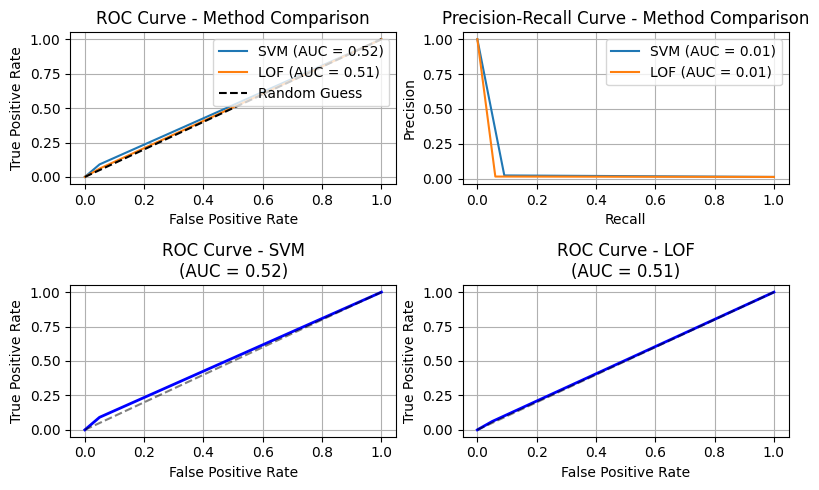

=== Anomaly Detection Performance Summary ===

SVM:
  ROC-AUC: 0.521
  PR-AUC:  0.014

LOF:
  ROC-AUC: 0.505
  PR-AUC:  0.013


In [78]:
true_labels = amber['Combined_Anomaly'].astype(int)
methods = {
    'SVM': amber['Anomaly_SVM'],
    'LOF': amber['Anomaly_LOF']}

results = {}
for method_name, predictions in methods.items():
    # ROC and PR AUC calculations
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(true_labels, predictions)
    pr_auc = average_precision_score(true_labels, predictions)

    results[method_name] = {
        'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc,
        'precision': precision, 'recall': recall, 'pr_auc': pr_auc}

fig, axes = plt.subplots(2, 2, figsize=(8, 5))

# ROC Curves
for method_name, result in results.items():
    axes[0, 0].plot(result['fpr'], result['tpr'],
                   label=f'{method_name} (AUC = {result["roc_auc"]:.2f})')
axes[0, 0].plot([0, 1], [0, 1], color='k', linestyle='--', label='Random Guess')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve - Method Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Precision-Recall Curves
for method_name, result in results.items():
    axes[0, 1].plot(result['recall'], result['precision'],
                   label=f'{method_name} (AUC = {result["pr_auc"]:.2f})')
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curve - Method Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Individual ROC Curves
for idx, (method_name, result) in enumerate(results.items()):
    axes[1, idx].plot(result['fpr'], result['tpr'], 'b-', linewidth=2)
    axes[1, idx].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[1, idx].set_xlabel('False Positive Rate')
    axes[1, idx].set_ylabel('True Positive Rate')
    axes[1, idx].set_title(f'ROC Curve - {method_name}\n(AUC = {result["roc_auc"]:.2f})')
    axes[1, idx].grid(True)

plt.tight_layout()
plt.show()

print("=== Anomaly Detection Performance Summary ===")
for method_name, result in results.items():
    print(f"\n{method_name}:")
    print(f"  ROC-AUC: {result['roc_auc']:.3f}")
    print(f"  PR-AUC:  {result['pr_auc']:.3f}")

## **Code Block 5.27:**
**Leaderboard for performance comparison of all ML models**

In [ ]:
amber.columns

Index(['Last Price', 'Volume', 'Returns', 'Volatility', 'RSI', 'RSI_Signal',
       'Z_Score', 'Rolling_Mean', 'Rolling_Std', 'Z_Anomaly',
       'Combined_Anomaly', 'Anomaly_IsoForest', 'True_Labels',
       'IsoForest_Anomaly_Label', 'LSTM_Anomaly', 'Autoencoder_Anomaly_Label',
       'Anomaly_SVM', 'Anomaly_LOF'],
      dtype='object')

In [79]:
methods = ['Z_Score', 'IsoForest', 'LSTM', 'Autoencoder', 'SVM', 'LOF']
amber['Anomaly_Autoencoder'] = (mse > threshold).astype(int)
results = []

for method in methods:
    if method == 'Z_Score':
        predictions = (abs(amber['Z_Score']) > 3).astype(int)

    elif method == 'IsoForest':
        predictions = (amber['Anomaly_IsoForest'] == -1).astype(int)

    elif method == 'LSTM':
        predictions = amber['LSTM_Anomaly'].astype(int)

    elif method == 'Autoencoder':
        predictions = amber['Anomaly_Autoencoder'].astype(int)

    elif method == 'SVM':
        predictions = amber['Anomaly_SVM'].astype(int)

    elif method == 'LOF':
        predictions = amber['Anomaly_LOF'].astype(int)

    true_labels = amber['Combined_Anomaly'].astype(int)

    precision = precision_score(true_labels, predictions, zero_division=0)
    recall = recall_score(true_labels, predictions, zero_division=0)
    f1 = f1_score(true_labels, predictions, zero_division=0)

    results.append({
        'Method': method,
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1, 4)})

results_df = pd.DataFrame(results)

print("Comparison Leaderboard of All Anomaly Detection Methods:")
print(results_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True))

Comparison Leaderboard of All Anomaly Detection Methods:
        Method  Precision  Recall  F1-Score
0      Z_Score     1.0000  1.0000    1.0000
1    IsoForest     0.9231  0.7273    0.8136
2         LSTM     0.1280  0.4848    0.2025
3          SVM     0.0238  0.0909    0.0377
4          LOF     0.0159  0.0606    0.0252
5  Autoencoder     0.0079  0.0303    0.0126


## **Code Block 5.28:**
**Visual comparison of ML models**


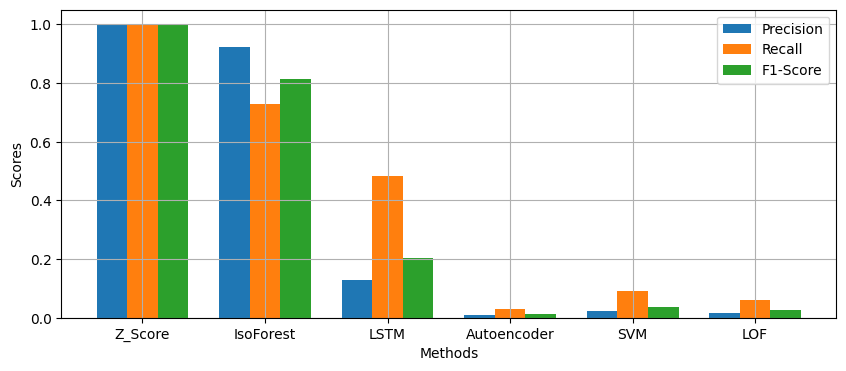

In [81]:
plt.figure(figsize=(10, 4))
x = np.arange(len(methods))
width = 0.25

plt.bar(x - width, results_df['Precision'], width, label='Precision')
plt.bar(x, results_df['Recall'], width, label='Recall')
plt.bar(x + width, results_df['F1-Score'], width, label='F1-Score')

plt.xlabel('Methods')
plt.ylabel('Scores')
plt.title('Comparison of Anomaly Detection Methods')
plt.xticks(x, methods)
plt.legend()
plt.grid()